# Introduction to the SorryDB Project

SorryDB is a continuously updated dataset of `sorry` statements from public Lean 4 repositories. These represent unproven mathematical propositions in ongoing formalization projects - from routine lemmas to major theorems across all areas of mathematics.

SorryDB aims to capture the authentic challenges mathematicians face when formalizing research, making it ideal for evaluating automatic theorem provers on real-world problems. The dataset is updated nightly by crawling repositories on [Reservoir](https://reservoir.lean-lang.org/), ensuring a fresh supply of diverse mathematical challenges.

**Key Features:**
- Real mathematical statements from active research projects
- Minimal data contamination (new problems added daily)
- Complete reproducibility information (repo, commit, build instructions)
- Spans all mathematical domains and difficulty levels

Let's explore what's inside the dataset.
For this we are going to look at the most recent **deduplicated list of sorries**, containing only unique goal strings.

To update the notebook, first press the `Run all` button up top.


In [1]:
import calendar
import random
from collections import Counter
from datetime import datetime
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import requests

SORRY_DB_URL = "https://raw.githubusercontent.com/SorryDB/sorrydb-data/refs/heads/master/deduplicated_sorries.json"
response = requests.get(SORRY_DB_URL)
data = response.json()
sorries = data["sorries"]
repo_urls = Counter(s["repo"]["remote"] for s in sorries)
print(
    f"The last nightly version of SorryDB contains {len(sorries)} deduplicated sorries from {len(repo_urls)} unique repositories."
)

The last nightly version of SorryDB contains 3751 deduplicated sorries from 27 unique repositories.


In [2]:
top_repos = repo_urls.most_common(10)
print("Top 10 repositories by number of sorries:")
for repo, count in top_repos:
    print(f"{repo.removeprefix('https://github.com/')}: {count} sorries")

Top 10 repositories by number of sorries:
Verified-zkEVM/ZKLib: 991 sorries
fpvandoorn/carleson: 484 sorries
yangky11/miniF2F-lean4: 416 sorries
leanprover-community/mathlib4: 415 sorries
dwrensha/compfiles: 409 sorries
PatrickMassot/GlimpseOfLean: 158 sorries
ImperialCollegeLondon/FLT: 147 sorries
AlexKontorovich/PrimeNumberTheoremAnd: 140 sorries
FormalizedFormalLogic/Foundation: 129 sorries
YaelDillies/LeanCamCombi: 79 sorries


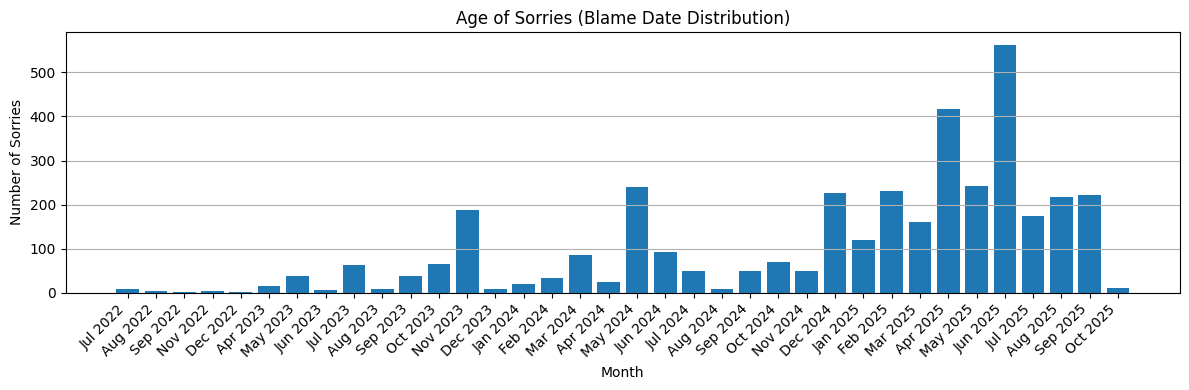

In [3]:
blame_dates = [datetime.fromisoformat(s["metadata"]["blame_date"]) for s in sorries]
blame_dates = [(date.year, date.month) for date in blame_dates]
date_counts = Counter(blame_dates)
sorted_dates = sorted(date_counts.keys())

plt.figure(figsize=(12, 4))
plt.xlabel("Month")
plt.ylabel("Number of Sorries")
plt.title("Age of Sorries (Blame Date Distribution)")
plt.bar(range(len(sorted_dates)), [date_counts[date] for date in sorted_dates])
x_labels = [f"{calendar.month_abbr[month]} {year}" for year, month in sorted_dates]
plt.xticks(range(len(sorted_dates)), x_labels, rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y")
plt.show()

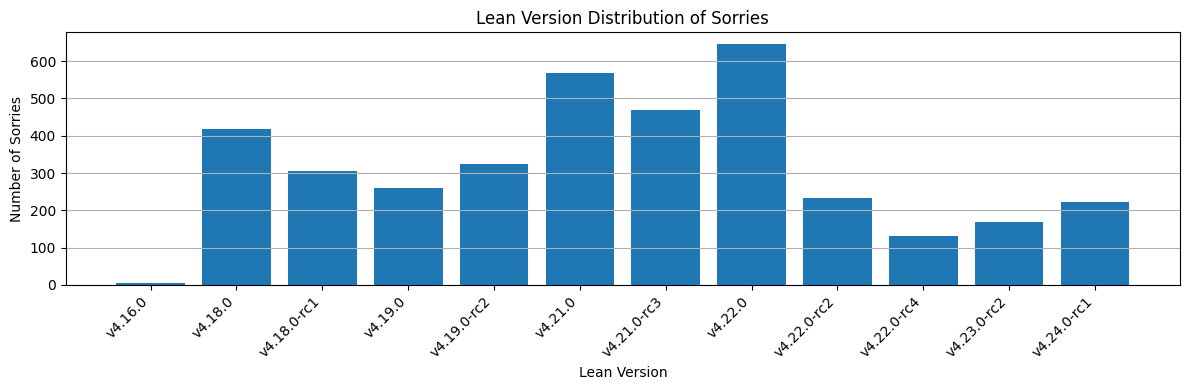

In [4]:
lean_versions = [
    s["repo"]["lean_version"] for s in sorries if "lean_version" in s["repo"]
]
lean_version_counts = Counter(lean_versions)
lean_version_counts = dict(
    sorted(lean_version_counts.items(), key=lambda item: item[0])
)

plt.figure(figsize=(12, 4))
plt.title("Lean Version Distribution of Sorries")
plt.xlabel("Lean Version")
plt.ylabel("Number of Sorries")
plt.bar(
    range(len(lean_version_counts)),
    [lean_version_counts[version] for version in lean_version_counts],
)
plt.xticks(
    range(len(lean_version_counts)),
    list(lean_version_counts.keys()),
    rotation=45,
    ha="right",
)
plt.tight_layout()
plt.grid(axis="y")
plt.show()

## An example Sorry

Let's select a random sorry from the database and look at the values in more detail:

In [5]:
sorry = random.choice(sorries)
pprint(sorry)

{'debug_info': {'goal': 'f : ℝ → ℝ\n'
                        'h₀ : ∀ (x : ℝ), f x = x ^ 2 + (18 * x + 30) - 2 * √(x '
                        '^ 2 + (18 * x + 45))\n'
                        "h₁ : Fintype ↑(f ⁻¹' {0})\n"
                        "⊢ ∏ x ∈ (f ⁻¹' {0}).toFinset, x = 20",
                'url': 'https://github.com/yangky11/miniF2F-lean4/blob/b5c6d30e75ae0e833d52d7a9e756e11ecfa92e24/MiniF2F/Test.lean#L1046'},
 'id': '9dba2c1263ce927b9996b6dcd24730f4b5468d73765ddef4177fc2fe246b3b37',
 'location': {'end_column': 47,
              'end_line': 1046,
              'path': 'MiniF2F/Test.lean',
              'start_column': 42,
              'start_line': 1046},
 'metadata': {'blame_date': '2025-03-21T12:42:00+01:00',
              'blame_email_hash': 'b262f07ece49',
              'inclusion_date': '2025-09-13T05:42:04.635029+00:00'},
 'repo': {'branch': 'main',
          'commit': 'b5c6d30e75ae0e833d52d7a9e756e11ecfa92e24',
          'lean_version': 'v4.21.0',
          'remote':

`repo`: This field contains all information necessary to rebuild the sorry locally.

`location`: Specifies how to find the sorry within the repo.

`id`: A unique id for this sorry, made by hashing the `repo` and `location` fields.

`metadata`: Mainly for internal use of the DB. `blame_date` is the date, when this sorry was commited.

`debug_info`: Help for debugging. `goal` is a pretty-printed proof goal and `url` is a direct link to the line of code on Github.



## Interacting with the SorryDB

The above sorry data structure is enough for a motivated participant to start working. However, we provide additional tools that help with setting up the sorry and verify the proof. Let's look at some example agents to get started.

For this we will use `sorrydb`'s Python module, installed via PyPI.
Note that we also install `elan`, Lean's version manager, as it will be needed for running many Lean versions, as each repository with a `sorry` may use a different version of Lean.
If you already have `elan` installed you may wish to skip this step.

In [ ]:
!pip install sorrydb

# Since this is a fresh environment, we also need to install elan and add it to the PATH
!curl https://raw.githubusercontent.com/leanprover/elan/master/elan-init.sh -sSf | sh -s -- -y
import os

os.environ["PATH"] = f"{Path('~/.elan/bin').expanduser()}{os.pathsep}{os.environ['PATH']}"

To illustrate interaction with the SorryDB we will use a simple example Lean project.
Our example agents work on a list of sorries, in our case there is just one example in this list:

In [6]:
SORRY_URL = "https://raw.githubusercontent.com/SorryDB/SorryDB/refs/heads/master/tests/mock_sorries/mock_sorry.json"
SORRY_PATH = Path("mock_sorry.json")

response = requests.get(SORRY_URL)
pprint(response.json())

SORRY_PATH.write_bytes(response.content)

{'documentation': 'single sorry, solved by rfl',
 'sorries': [{'debug_info': {'goal': '⊢ 1 + 1 = 2',
                             'url': 'https://github.com/austinletson/sorryClientTestRepo/blob/78202012bfe87f99660ba2fe5973eb1a8110ab64/SorryClientTestRepo/BasicWithElabTactic.lean#L4'},
              'id': '000000000000',
              'location': {'end_column': 7,
                           'end_line': 4,
                           'path': 'SorryClientTestRepo/BasicWithElabTactic.lean',
                           'start_column': 2,
                           'start_line': 4},
              'metadata': {'blame_date': '2024-01-01T00:00:00+00:00',
                           'blame_email_hash': 'mock_hash_1',
                           'inclusion_date': '2024-01-01T00:00:00+00:00'},
              'repo': {'branch': 'branch1',
                       'commit': '78202012bfe87f99660ba2fe5973eb1a8110ab64',
                       'lean_version': 'v4.16.0',
                       'remote': 'https

1111

In sorrydb we have prepared templates for an agent, which can process this JSON. We can customize its behaviour by using different proof strategies. In this example we will use a simple `RflStrategy`. For each sorry:
- First `JsonAgent` will setup the Lean project defined in the sorry.
- Next, `RflStrategy` will attempt to prove the sorry using `rfl`.

In [10]:
from sorrydb.agents.json_agent import JsonAgent
from sorrydb.agents.rfl_strategy import RflStrategy

# Absolute folder path, where the sorries will be set up in.
# You can treat this as a cache/temporary folder.
LEAN_DATA_PATH = Path("/content/lean_data")

# Path to the output log file of the agent.
OUTPUT_PATH = Path("output.log")

agent = JsonAgent(RflStrategy(), LEAN_DATA_PATH)
agent.process_sorries(SORRY_PATH, OUTPUT_PATH)

# Open the output log file
print(OUTPUT_PATH.read_text())

⚠ [2/8] Replayed SorryClientTestRepo.Basic
Build completed successfully.
[
    {
        "sorry": {
            "repo": {
                "remote": "https://github.com/austinletson/sorryClientTestRepo",
                "branch": "branch1",
                "commit": "78202012bfe87f99660ba2fe5973eb1a8110ab64",
                "lean_version": "v4.16.0"
            },
            "location": {
                "path": "SorryClientTestRepo/BasicWithElabTactic.lean",
                "start_line": 4,
                "start_column": 2,
                "end_line": 4,
                "end_column": 7
            },
            "debug_info": {
                "goal": "\u22a2 1 + 1 = 2",
                "url": "https://github.com/austinletson/sorryClientTestRepo/blob/78202012bfe87f99660ba2fe5973eb1a8110ab64/SorryClientTestRepo/BasicWithElabTactic.lean#L4"
            },
            "metadata": {
                "blame_email_hash": "mock_hash_1",
                "blame_date": "2024-01-01T00:00:00+00:

`{"proof": "rfl"}` indicates that the agent has found a valid proof for the sorry: `rfl`.

### Custom Strategies

Let's create a custom strategy to attempt proving this sorry. Instead of using `rfl` we will attempt to prove using `simp`. For this its easiest to inherit from `SorryStrategy` and customize the `prove_sorry` method:

In [12]:
from sorrydb.agents.json_agent import SorryStrategy
from sorrydb.database.sorry import Sorry


class SimpStrategy(SorryStrategy):
    def prove_sorry(self, repo_path: Path, sorry: Sorry) -> str | None:
        # We could look at the Sorry to inform our decision but for now we just attempt `simp`.
        return "simp"


agent = JsonAgent(SimpStrategy(), LEAN_DATA_PATH)
agent.process_sorries(SORRY_PATH, OUTPUT_PATH)

# Open the output log file
print(OUTPUT_PATH.read_text())

⚠ [2/8] Replayed SorryClientTestRepo.Basic
Build completed successfully.
[
    {
        "sorry": {
            "repo": {
                "remote": "https://github.com/austinletson/sorryClientTestRepo",
                "branch": "branch1",
                "commit": "78202012bfe87f99660ba2fe5973eb1a8110ab64",
                "lean_version": "v4.16.0"
            },
            "location": {
                "path": "SorryClientTestRepo/BasicWithElabTactic.lean",
                "start_line": 4,
                "start_column": 2,
                "end_line": 4,
                "end_column": 7
            },
            "debug_info": {
                "goal": "\u22a2 1 + 1 = 2",
                "url": "https://github.com/austinletson/sorryClientTestRepo/blob/78202012bfe87f99660ba2fe5973eb1a8110ab64/SorryClientTestRepo/BasicWithElabTactic.lean#L4"
            },
            "metadata": {
                "blame_email_hash": "mock_hash_1",
                "blame_date": "2024-01-01T00:00:00+00:

A failing proof will be returned as `None` (Python) which is represented as `null` (JSON). If we use e.g. `aesop` there are missing imports and the proof will not be successful:

* First we see a `WARNING` during `process_sorries()`.
* In the output we see `{"proof": null}`.

In [13]:
class AesopStrategy(SorryStrategy):
    def prove_sorry(self, repo_path: Path, sorry: Sorry) -> str | None:
        return "aesop"


agent = JsonAgent(AesopStrategy(), LEAN_DATA_PATH)
agent.process_sorries(SORRY_PATH, OUTPUT_PATH)

# Open the output log file
print(OUTPUT_PATH.read_text())

⚠ [2/8] Replayed SorryClientTestRepo.Basic
Build completed successfully.


Failed to analyze modified file: REPL returned errors: unknown tactic; unsolved goals
⊢ 1 + 1 = 2


[
    {
        "sorry": {
            "repo": {
                "remote": "https://github.com/austinletson/sorryClientTestRepo",
                "branch": "branch1",
                "commit": "78202012bfe87f99660ba2fe5973eb1a8110ab64",
                "lean_version": "v4.16.0"
            },
            "location": {
                "path": "SorryClientTestRepo/BasicWithElabTactic.lean",
                "start_line": 4,
                "start_column": 2,
                "end_line": 4,
                "end_column": 7
            },
            "debug_info": {
                "goal": "\u22a2 1 + 1 = 2",
                "url": "https://github.com/austinletson/sorryClientTestRepo/blob/78202012bfe87f99660ba2fe5973eb1a8110ab64/SorryClientTestRepo/BasicWithElabTactic.lean#L4"
            },
            "metadata": {
                "blame_email_hash": "mock_hash_1",
                "blame_date": "2024-01-01T00:00:00+00:00",
                "inclusion_date": "2024-01-01T00:00:00+00:00"
      

## Next Steps

* Check out the [LLMStrategy](https://github.com/SorryDB/SorryDB/blob/master/sorrydb/agents/llm_strategy.py) for a more advanced example.
* Have a look at the [README](https://github.com/SorryDB/SorryDB) and the links to further documentation.
* Look out for our leaderboard, where agents can compete. Coming soon™